In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import time
from nltk.stem.snowball import SnowballStemmer
import re
from gensim.parsing.preprocessing import remove_stopwords
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# **Loading the dataset :**

In [4]:
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
print(fake.shape)
print(true.shape)

(23481, 4)
(21417, 4)


In [7]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


**There are no null values in the dataset**

In [8]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


**There are no null values in the dataset**

**Creating class labels :**

In [11]:
fake['class'] = 0
true['class'] = 1

# **Data Visualisation :**

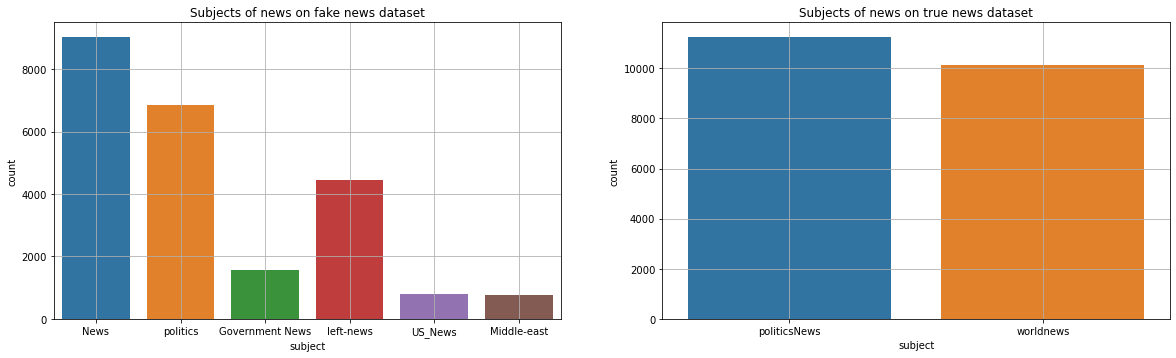

In [12]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.countplot('subject',data=fake)
plt.title("Subjects of news on fake news dataset")
plt.grid()

plt.subplot(2,2,2)
sns.countplot('subject',data=true)
plt.title("Subjects of news on true news dataset")
plt.grid()

plt.show()

**subject:politics in the fake news dataset is same as the subject :politicsNews in the true news dataset**
**Therefore changing them to a common name.**

In [13]:
for i in range(len(true['subject'])):
    if true['subject'][i] == 'politicsNews':
        true['subject'][i] = 'politics'
        
true['subject'][10]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


'politics'

**Combining the datasets:**

In [14]:
data = pd.concat([fake,true],axis=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


**Sorting the datasets by date:**

In [15]:
data = pd.DataFrame.sort_values(data,by=['date'])
data.head()

,title,text,subject,date,class
9084,JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...,We ve been covering the curious case of DOJ of...,politics,14-Feb-18,0
9083,The DIRTY TRUTH About DACA Recipients…Where Th...,"Yesterday, a second U.S. judge on Tuesday bloc...",politics,15-Feb-18,0
9082,HUH? RAPPER JAY-Z Compares Trayvon Martin to M...,Rapper Jay-Z attended the Peace Walk & Peace T...,politics,15-Feb-18,0
9081,SC STATE REP Who is a Former Cop Proposes Smar...,WHO BETTER THAN A FORMER POLICE OFFICER TO UND...,politics,15-Feb-18,0
9080,JUST IN: Senate Rejects Immigration Bill…Trump...,How could the Senate be so lame in their effor...,politics,15-Feb-18,0


In [16]:
#dropping unnecessary column : date
data = data.reset_index(drop=True)
data = data.drop('date',axis=1)
data.head()

,title,text,subject,class
0,JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...,We ve been covering the curious case of DOJ of...,politics,0
1,The DIRTY TRUTH About DACA Recipients…Where Th...,"Yesterday, a second U.S. judge on Tuesday bloc...",politics,0
2,HUH? RAPPER JAY-Z Compares Trayvon Martin to M...,Rapper Jay-Z attended the Peace Walk & Peace T...,politics,0
3,SC STATE REP Who is a Former Cop Proposes Smar...,WHO BETTER THAN A FORMER POLICE OFFICER TO UND...,politics,0
4,JUST IN: Senate Rejects Immigration Bill…Trump...,How could the Senate be so lame in their effor...,politics,0


# **Text Preprocessing :**

In [18]:
def remove_shortforms(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_special_char(text):
    text = re.sub('[^A-Za-z0-9]+'," ",text)
    return text

def remove_wordswithnum(text):
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

def lowercase(text):
    text = text.lower()
    return text

def remove_stop_words(text):
    text = remove_stopwords(text)
    return text

st = SnowballStemmer(language='english')
def stemming(text):
    r= []
    for word in text :
        a = st.stem(word)
        r.append(a)
    return r

def listToString(s):  
    str1 = " "   
    return (str1.join(s))

In [19]:
start_time = time.time()
for i in range(len(data['text'])):
    data['text'][i] = remove_shortforms(data['text'][i])
    data['text'][i] = remove_special_char(data['text'][i])
    data['text'][i] = remove_wordswithnum(data['text'][i])
    data['text'][i] = lowercase(data['text'][i])
    data['text'][i] = remove_stop_words(data['text'][i])
    text = data['text'][i]
    text = text.split()
    data['text'][i] = stemming(text)
    s = data['text'][i]
    data['text'][i] = listToString(s)
print("Time taken to preprocess : ",time.time()-start_time," seconds")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Time taken to preprocess :  281.3516249656677  seconds


In [20]:
start_time = time.time()
for i in range(len(data['title'])):
    data['title'][i] = remove_shortforms(data['title'][i])
    data['title'][i] = remove_special_char(data['title'][i])
    data['title'][i] = remove_wordswithnum(data['title'][i])
    data['title'][i] = lowercase(data['title'][i])
    data['title'][i] = remove_stop_words(data['title'][i])
    text = data['title'][i]
    text = text.split()
    data['title'][i] = stemming(text)
    s = data['title'][i]
    data['title'][i] = listToString(s)
print("Time taken to preprocess : ",time.time()-start_time," seconds")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Time taken to preprocess :  95.81004691123962  seconds


In [21]:
start_time = time.time()
for i in range(len(data['subject'])):
    data['subject'][i] = remove_shortforms(data['subject'][i])
    data['subject'][i] = remove_special_char(data['subject'][i])
    data['subject'][i] = remove_wordswithnum(data['subject'][i])
    data['subject'][i] = lowercase(data['subject'][i])
    data['subject'][i] = remove_stop_words(data['subject'][i])
    text = data['subject'][i]
    text = text.split()
    data['subject'][i] = stemming(text)
    s = data['subject'][i]
    data['subject'][i] = listToString(s)
print("Time taken to preprocess : ",time.time()-start_time," seconds")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Time taken to preprocess :  78.57464647293091  seconds


In [22]:
data.head()

,title,text,subject,class
0,crook doj offici t reveal wife paid fusion gps...,ve cover curious case doj offici bruce ohr wif...,polit,0
1,dirti truth daca recipi come crimin record got,yesterday second u s judg tuesday block presid...,polit,0
2,huh rapper jay z compar trayvon martin mlk gan...,rapper jay z attend peac walk peac talk miami ...,polit,0
3,sc state rep cop propos smart gun law campus c...,better polic offic understand gun equal better...,polit,0
4,senat reject immigr trump call total catastroph,senat lame effort produc immigr senat ted cruz...,polit,0


**Combining the texts,titles and the subjects :**

In [24]:
Combined_text = [None] * len(data['text'])
for i in range(len(data['title'])):
    Combined_text[i] = data['text'][i] + " " + data['title'][i] + " " + data['subject'][i]
    
data['combined_text'] = Combined_text

In [25]:
#dropping the unnecessary columns
data = pd.DataFrame.drop(data,columns=['title','text','subject'],axis=1)
data.head()

,class,combined_text
0,0,ve cover curious case doj offici bruce ohr wif...
1,0,yesterday second u s judg tuesday block presid...
2,0,rapper jay z attend peac walk peac talk miami ...
3,0,better polic offic understand gun equal better...
4,0,senat lame effort produc immigr senat ted cruz...


# **Bag Of Words and TF-IDF encoding of the combined text:**

In [27]:
bow = CountVectorizer(ngram_range=(1,2))
bow_text = bow.fit_transform(data['combined_text'])

In [30]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf_text = tfidf.fit_transform(data['combined_text'])

In [31]:
print(bow_text.shape)
print(tfidf_text.shape)

(44898, 3014285)
(44898, 3014285)


# **Train-Test Split(Time based Splitting) :**

In [32]:
labels = data['class'].reset_index(drop=True)
labels.shape

(44898,)

In [33]:
# splitting in 70% train and 30% test
X_train_bow = bow_text[:31428]
X_test_bow = bow_text[31428:]
X_train_tfidf = tfidf_text[:31428]
X_test_tfidf = tfidf_text[31428:]
Y_train = labels[:31428]
Y_test = labels[31428:]

**Splitted data visualisation :**

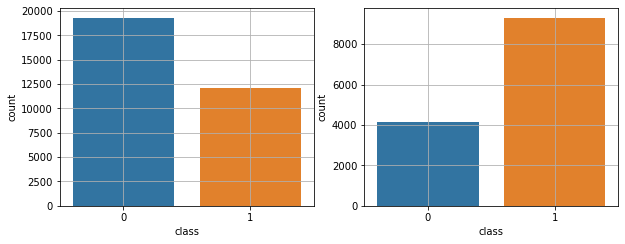

In [35]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.countplot(Y_train)
plt.grid()

plt.subplot(2,2,2)
sns.countplot(Y_test)
plt.grid()

plt.show()

**Confusion Matrix along with Precision and Recall matrix :**

In [38]:
def plot_conf_matrix(Y_test,Y_pred):
    conf = confusion_matrix(Y_test,Y_pred)
    recall =(((conf.T)/(conf.sum(axis=1))).T)
    precision =(conf/conf.sum(axis=0))

    class_labels = [0,1]
    plt.figure(figsize=(10,8))
    sns.heatmap(conf,annot=True,fmt=".3f",cmap="YlOrBr",xticklabels=class_labels,yticklabels=class_labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    plt.figure(figsize=(10,8))
    sns.heatmap(precision,annot=True,fmt=".3f",cmap="YlOrBr",xticklabels=class_labels,yticklabels=class_labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    plt.figure(figsize=(10,8))
    sns.heatmap(recall,annot=True,fmt=".3f",cmap="YlOrBr",xticklabels=class_labels,yticklabels=class_labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# **ML Models :**

In [40]:
summary = []

# **Linear SVM :**

The train loss is :  9.992007221626413e-16
The test loss is :  0.1487212633719398
Accuracy :  99.56941351150705


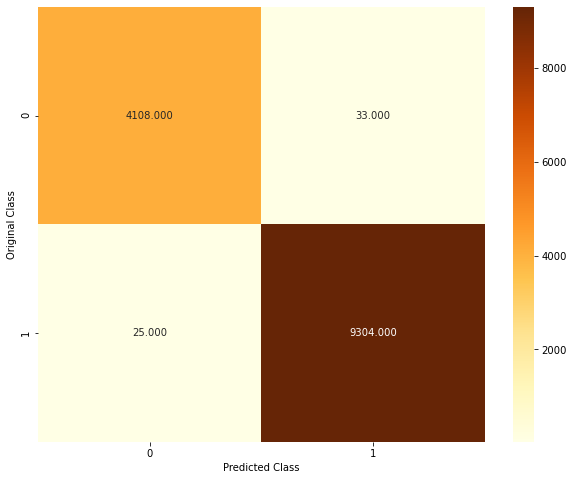

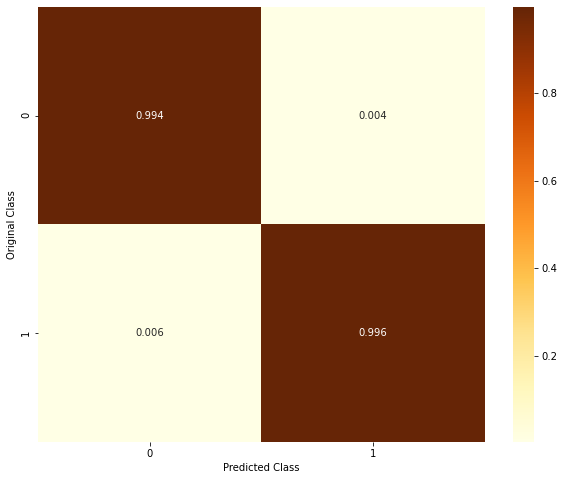

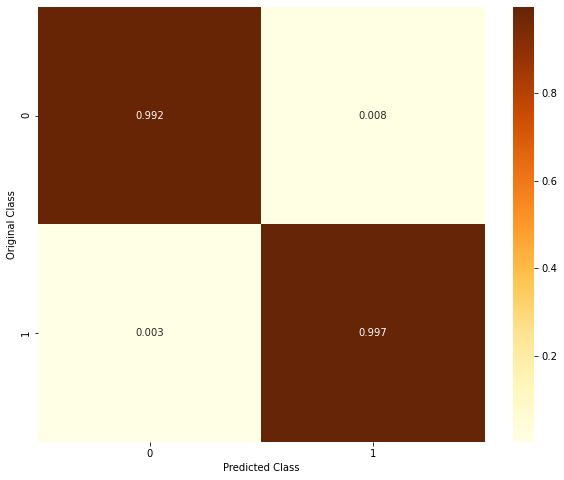

NameError: name 'recall_score' is not defined

In [47]:
li_svm = SVC(kernel='linear')
li_svm.fit(X_train_bow,Y_train)

train_pred = li_svm.predict(X_train_bow)
print("The train loss is : ",log_loss(Y_train,train_pred))

test_pred = li_svm.predict(X_test_bow)
print("The test loss is : ",log_loss(Y_test,test_pred))

print("Accuracy : ",accuracy_score(Y_test,test_pred)*100)
plot_conf_matrix(Y_test,test_pred)

print("Recall:",recall_score(y_test, test_pred)*100)

# **KNN :**

The train loss is :  6.619204860694422
The test loss is :  14.107843828463743


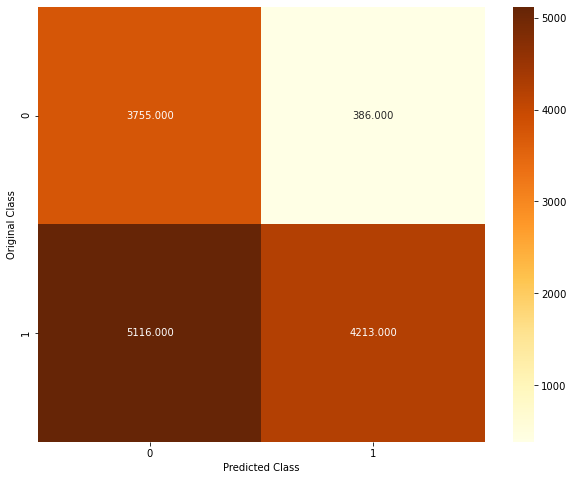

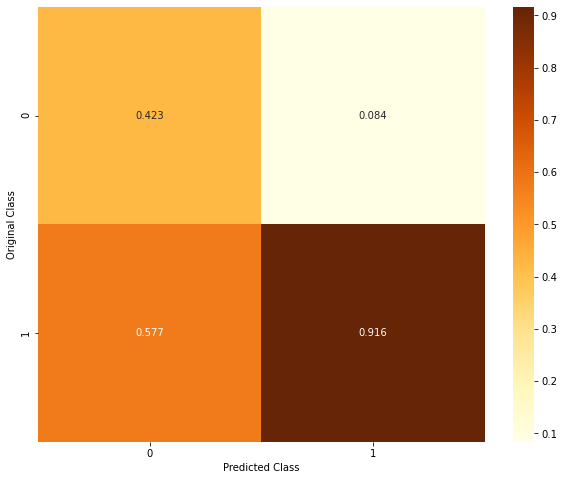

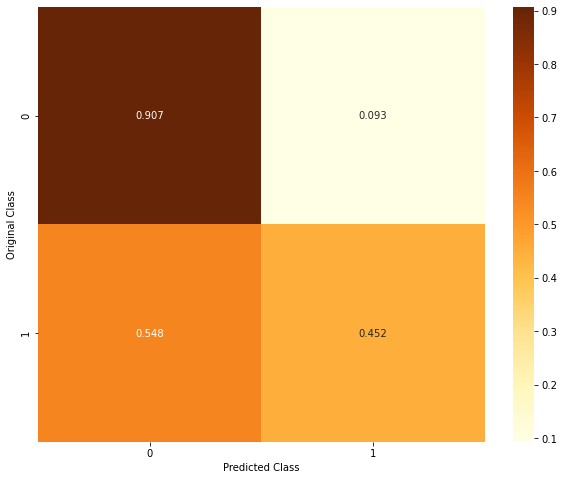

Accuracy : 59.15367483296213


In [45]:
knn = KNeighborsClassifier()
knn.fit(X_train_bow,Y_train)

train_pred = knn.predict(X_train_bow)
print("The train loss is : ",log_loss(Y_train,train_pred))

test_pred = knn.predict(X_test_bow)
print("The test loss is : ",log_loss(Y_test,test_pred))

plot_conf_matrix(Y_test,test_pred)
print("Accuracy :",accuracy_score(Y_test,test_pred)*100)



# **Summary of models :**

Accuracy of SVM : 99.56941351150705 
Accuracy of KNN : 59.15367483296213 

hence we can come to a conclusion that for svm is better for fake news dectection rather than knn as the precision in knn is lower .